# ParkSense: Supabase Dataset Analysis

**Goal**: Comprehensive EDA on the Supabase dataset (762k rows, 3% ghost bays).

**Analyses**:
1. Data Coverage Range
2. Hourly Occupancy (Color-coded peaks)
3. Geospatial Heatmap (Interactive)
4. Stay Duration
5. Target Variable Balance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Prepare Data

In [2]:
# Load Supabase snapshots
print("Loading Supabase data...")
df = pd.read_csv('../data/supabase_snapshots.csv', parse_dates=['status_timestamp'])
print(f"Total Rows: {len(df):,}")

# Load Static Bays for location data
bays = pd.read_csv('../data/on-street-parking-bays.csv')
bays = bays.dropna(subset=['KerbsideID'])
bays['KerbsideID'] = bays['KerbsideID'].astype(str).str.replace(r'\.0$', '', regex=True)

# Clean Supabase IDs
df['kerbsideid'] = df['kerbsideid'].astype(str).str.replace(r'\.0$', '', regex=True)

# Merge to add Latitude/Longitude
print("Merging with static map...")
df_merged = df.merge(
    bays[['KerbsideID', 'Latitude', 'Longitude']], 
    left_on='kerbsideid', 
    right_on='KerbsideID', 
    how='inner'
)

print(f"Merged Rows (after dropping ghost bays): {len(df_merged):,}")
print(f"Ghost Bays Dropped: {len(df) - len(df_merged):,}")

Loading Supabase data...
Total Rows: 762,037
Merging with static map...
Merged Rows (after dropping ghost bays): 751,886
Ghost Bays Dropped: 10,151


## 2. Data Coverage Range

In [3]:
min_date = df_merged['status_timestamp'].min()
max_date = df_merged['status_timestamp'].max()
duration = max_date - min_date

print(f"Start Date: {min_date}")
print(f"End Date:   {max_date}")
print(f"Total Coverage: {duration.days} days ({duration.days / 7:.1f} weeks)")
print(f"Total Coverage: {duration.days / 30:.1f} months")

Start Date: 2022-09-13 04:38:23+00:00
End Date:   2025-12-18 10:16:57+00:00
Total Coverage: 1192 days (170.3 weeks)
Total Coverage: 39.7 months


## 3. Feature Engineering

In [4]:
# Extract time features
df_merged['hour'] = df_merged['status_timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['status_timestamp'].dt.dayofweek
df_merged['is_weekend'] = df_merged['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create target variable
df_merged['is_occupied'] = (df_merged['status'] == 'Present').astype(int)

print("Features created.")

Features created.


## 4. Hourly Occupancy (Highlighted Peaks)

In [ ]:
# Filter to only the last 30 days of data
from datetime import timedelta

max_date = df_merged['status_timestamp'].max()
cutoff_date = max_date - timedelta(days=30)

df_recent = df_merged[df_merged['status_timestamp'] >= cutoff_date].copy()

print(f"Filtered to last 30 days: {len(df_recent):,} records")
print(f"Date range: {df_recent['status_timestamp'].min()} to {df_recent['status_timestamp'].max()}")

# Now recalculate hourly occupancy with recent data
hourly_occupancy = df_recent.groupby('hour')['is_occupied'].mean() * 100

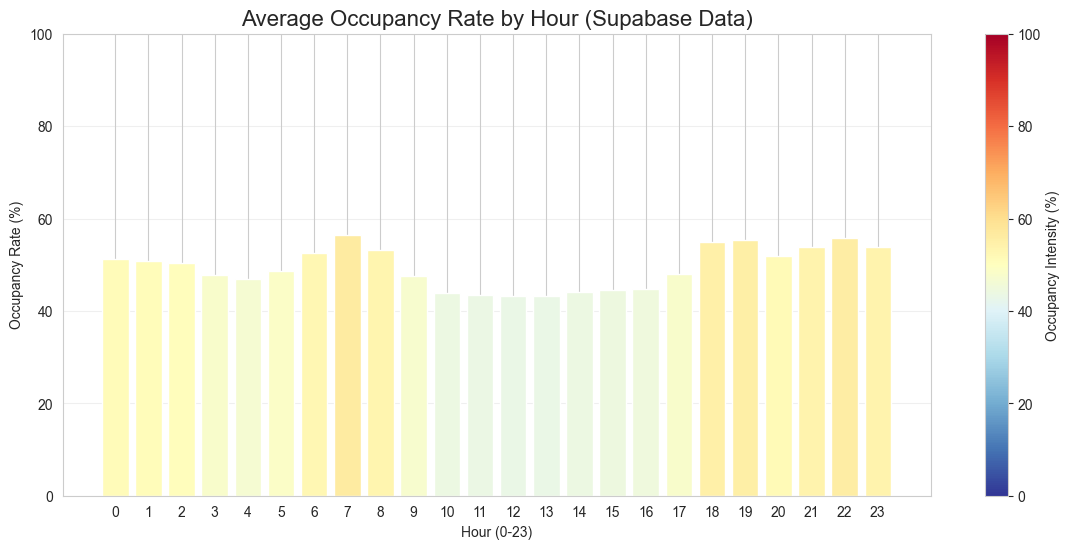

In [16]:
# Calculate occupancy rate by hour
hourly_occupancy = df_merged.groupby('hour')['is_occupied'].mean() * 100

# Color map: Use a wider range for better visual distinction
# Normalize from 0-100 instead of min-max to show true scale
norm = plt.Normalize(0, 100)  # Changed from (hourly_occupancy.min(), hourly_occupancy.max())
colors = plt.cm.RdYlBu_r(norm(hourly_occupancy.values))

plt.figure(figsize=(14, 6))
bars = plt.bar(hourly_occupancy.index, hourly_occupancy.values, color=colors)
plt.title('Average Occupancy Rate by Hour (Supabase Data)', fontsize=16)
plt.xlabel('Hour (0-23)')
plt.ylabel('Occupancy Rate (%)')
plt.xticks(range(0, 24))
plt.ylim(0, 100)

# Add color bar with 0-100 scale
sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Occupancy Intensity (%)')

plt.grid(axis='y', alpha=0.3)
plt.show()

In [17]:
# DIAGNOSTIC: Check data distribution by hour
print("=== DATA QUALITY CHECK ===\n")

# 1. How many records per hour?
records_per_hour = df_merged.groupby('hour').size()
print("Records per hour:")
print(records_per_hour)
print(f"\nMin records/hour: {records_per_hour.min()}")
print(f"Max records/hour: {records_per_hour.max()}")

# 2. What's the status distribution?
print("\n\nStatus distribution:")
print(df_merged['status'].value_counts())
print(f"\nOverall occupancy rate: {df_merged['is_occupied'].mean() * 100:.2f}%")

# 3. Check a few sample records at 3 AM
print("\n\nSample records at 3 AM:")
sample_3am = df_merged[df_merged['hour'] == 3][['status_timestamp', 'kerbsideid', 'status', 'is_occupied']].head(10)
print(sample_3am)

# 4. Check unique dates in dataset
df_merged['date'] = df_merged['status_timestamp'].dt.date
print(f"\n\nUnique dates: {df_merged['date'].nunique()}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")

=== DATA QUALITY CHECK ===

Records per hour:
hour
0     46838
1     46758
2     46038
3     47015
4     47940
5     44616
6     42290
7     34931
8     28973
9     28596
10    30588
11    28207
12    23882
13    17433
14    13734
15    11680
16    10419
17     9858
18    12886
19    22111
20    30867
21    36465
22    43930
23    45831
dtype: int64

Min records/hour: 9858
Max records/hour: 47940


Status distribution:
status
Present       376851
Unoccupied    375035
Name: count, dtype: int64

Overall occupancy rate: 50.12%


Sample records at 3 AM:
              status_timestamp kerbsideid      status  is_occupied
1740 2025-11-28 03:56:34+00:00       7895  Unoccupied            0
1741 2025-11-28 03:56:30+00:00      11934  Unoccupied            0
1742 2025-11-28 03:52:42+00:00      18630  Unoccupied            0
1743 2025-11-28 03:50:00+00:00      51815     Present            1
1744 2025-11-28 03:48:25+00:00      63620     Present            1
1745 2025-11-28 03:37:39+00:00      16435 

## 5. Geospatial Heatmap (Interactive)

In [6]:
# Calculate activity frequency per location
location_activity = df_merged.groupby(['Latitude', 'Longitude']).size().reset_index(name='count')

# Create map centered on Melbourne CBD
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=14)

# Add heatmap
HeatMap(
    data=location_activity[['Latitude', 'Longitude', 'count']].values,
    radius=12,
    blur=18,
    max_zoom=1
).add_to(m)

# Save map
m.save('supabase_parking_heatmap.html')
print("Interactive heatmap saved to: supabase_parking_heatmap.html")
m

Interactive heatmap saved to: supabase_parking_heatmap.html


## 6. Stay Duration Analysis

**Note**: The Supabase data contains snapshots (status at a point in time), not arrival/departure events.
We can analyze the **time between status changes** for each sensor as a proxy for stay duration.

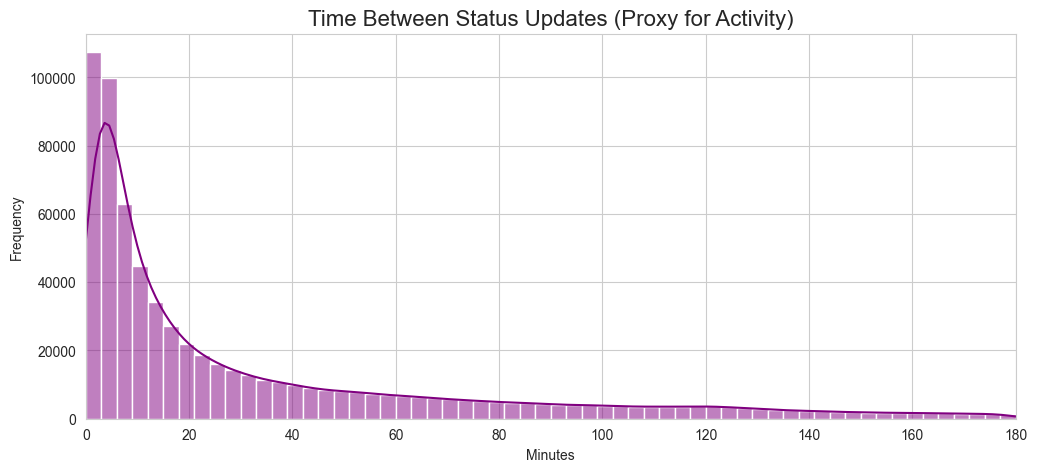

Median time between updates: 13.8 minutes
Mean time between updates: 32.9 minutes


In [7]:
# Sort by sensor and timestamp
df_sorted = df_merged.sort_values(['kerbsideid', 'status_timestamp'])

# Calculate time difference between consecutive snapshots for each sensor
df_sorted['time_diff'] = df_sorted.groupby('kerbsideid')['status_timestamp'].diff()

# Convert to minutes
df_sorted['time_diff_min'] = df_sorted['time_diff'].dt.total_seconds() / 60

# Filter reasonable durations (exclude very long gaps which indicate data collection pauses)
duration_data = df_sorted[(df_sorted['time_diff_min'] > 0) & (df_sorted['time_diff_min'] < 180)]

plt.figure(figsize=(12, 5))
sns.histplot(duration_data['time_diff_min'], bins=60, color='purple', kde=True)
plt.title('Time Between Status Updates (Proxy for Activity)', fontsize=16)
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.xlim(0, 180)
plt.show()

print(f"Median time between updates: {duration_data['time_diff_min'].median():.1f} minutes")
print(f"Mean time between updates: {duration_data['time_diff_min'].mean():.1f} minutes")

## 7. Target Variable Balance

Target Variable Balance:
Unoccupied (0): 49.88%
Occupied (1):   50.12%


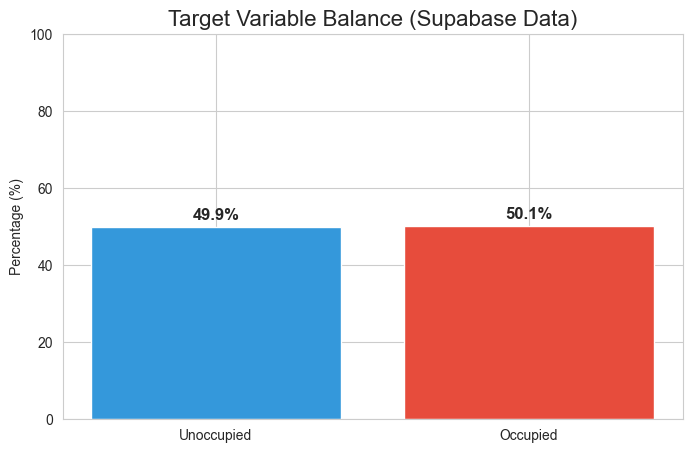

In [14]:
# Calculate balance
balance = df_merged['is_occupied'].value_counts(normalize=True) * 100
print("Target Variable Balance:")
print(f"Unoccupied (0): {balance[0]:.2f}%")
print(f"Occupied (1):   {balance[1]:.2f}%")

# Visualize
plt.figure(figsize=(8, 5))
colors_balance = ['#3498db', '#e74c3c']
plt.bar(['Unoccupied', 'Occupied'], 
        [balance[0], balance[1]], 
        color=colors_balance)
plt.title('Target Variable Balance (Supabase Data)', fontsize=16)
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)

# Add percentage labels on bars
for i, v in enumerate([balance[0], balance[1]]):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.show()

## 8. Export Processed Data

In [9]:
# Save processed data for model training
OUTPUT_PATH = '../data/supabase_processed.csv'
df_merged.to_csv(OUTPUT_PATH, index=False)
print(f"Processed data saved to: {OUTPUT_PATH}")
print(f"Total rows: {len(df_merged):,}")

Processed data saved to: ../data/supabase_processed.csv
Total rows: 751,886
